Finding a Person in the Dark - Take-Home Assignment
Author: Amir Izimov
Description: Low-light pedestrian detection challenge

# 1. Setup

install all dependencies

In [4]:
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install -q numpy pandas matplotlib seaborn tqdm opencv-python
!pip install -q ultralytics albumentations pycocotools scikit-learn



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import cv2
import torch
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("coolwarm")
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device.upper()}, PyTorch version: {torch.__version__}")

DATA_DIR = "data"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


Running on CUDA, PyTorch version: 2.5.1+cu121


In [10]:
!nvidia-smi


Sun Nov  2 22:08:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P5              4W /   80W |     962MiB /   8188MiB |     37%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Dataset loading and EDA

Train images: 11782
Test images : 3248
040165.jpg person 116 586 73 250 person 180 609 86 258 person 761 358 132 234 person 482 101 83 246 person 62 923 65 101
030350.jpg person 1054 498 134 266 person 867 894 174 130
050074.jpg person 219 3 97 233 person 331 383 122 251 person 453 366 96 219 person 1077 84 113 264
Loaded 11782 training records


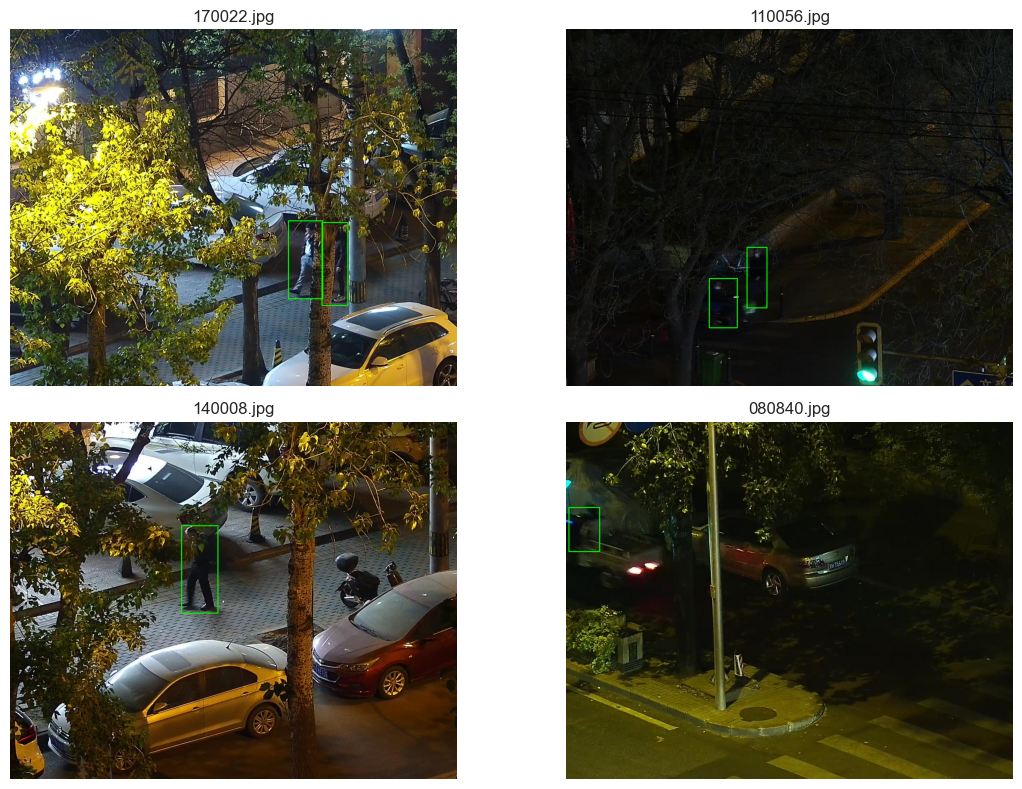

In [11]:


from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import random

# main paths
DATA_ROOT = Path("find-person-in-the-dark")
TRAIN_IMG_DIR = DATA_ROOT / "train" / "train" / "train_images"
TRAIN_ANN_PATH = DATA_ROOT / "train" / "train" / "train_annotations"
TEST_IMG_DIR = DATA_ROOT / "test" / "test" / "test_images"

TRAIN_TXT = DATA_ROOT / "train_data.txt"
TEST_TXT  = DATA_ROOT / "test_data.txt"

print("Train images:", len(list(TRAIN_IMG_DIR.glob("*.jpg"))))
print("Test images :", len(list(TEST_IMG_DIR.glob("*.jpg"))))
with open(TRAIN_TXT) as f:
    for i in range(3):
        print(f.readline().strip())

# --------------------------------------------------------------
# Parse the annotation file into a simple list
# each line: filename  person  x y w h  person  x y w h ...
# --------------------------------------------------------------
def load_annotations(txt_path):
    data = []
    with open(txt_path) as f:
        for line in f:
            parts = line.strip().split()
            fname = parts[0]
            boxes = []
            i = 1
            while i < len(parts):
                label = parts[i]
                x, y, w, h = map(int, parts[i+1:i+5])
                boxes.append((label, x, y, w, h))
                i += 5
            data.append({"image": fname, "boxes": boxes})
    return data

train_data = load_annotations(TRAIN_TXT)
print(f"Loaded {len(train_data)} training records")

# --------------------------------------------------------------
# Show a few sample images with bounding boxes
# --------------------------------------------------------------
def show_samples(data_list, img_dir, n=4):
    plt.figure(figsize=(12, 8))
    samples = random.sample(data_list, n)
    for idx, item in enumerate(samples):
        img_path = img_dir / item["image"]
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        for _, x, y, w, h in item["boxes"]:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, n//2, idx+1)
        plt.imshow(img_rgb)
        plt.title(item["image"])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_data, TRAIN_IMG_DIR)



Calculating brightness for training images...


100%|██████████| 11782/11782 [02:55<00:00, 66.98it/s]


Calculating brightness for test images...


100%|██████████| 3248/3248 [00:47<00:00, 68.71it/s]


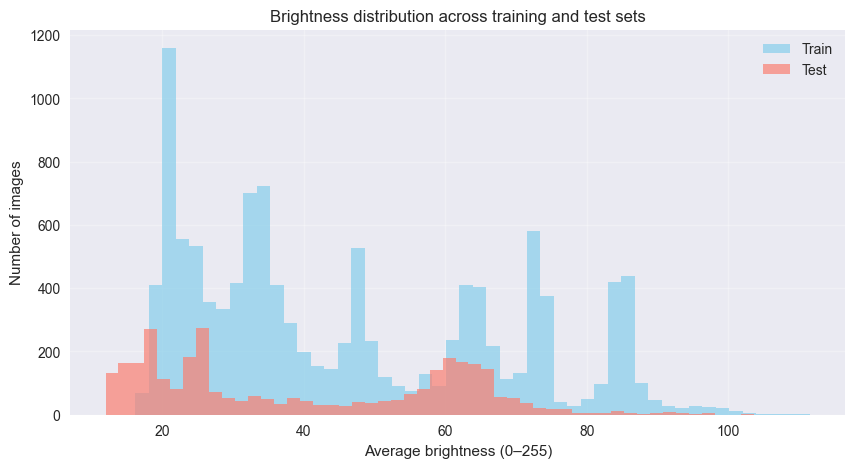

Train mean brightness: 46.25
Test mean brightness : 40.30


In [13]:
def calculate_brightness(img_path):
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# compute brightness for train and test sets
train_brightness = []
test_brightness = []

print("Calculating brightness for training images...")
for img_path in tqdm(list(TRAIN_IMG_DIR.glob("*.jpg"))):
    b = calculate_brightness(img_path)
    if b is not None:
        train_brightness.append(b)

print("Calculating brightness for test images...")
for img_path in tqdm(list(TEST_IMG_DIR.glob("*.jpg"))):
    b = calculate_brightness(img_path)
    if b is not None:
        test_brightness.append(b)

# plot histograms
plt.figure(figsize=(10,5))
plt.hist(train_brightness, bins=50, alpha=0.7, label="Train", color='skyblue')
plt.hist(test_brightness, bins=50, alpha=0.7, label="Test", color='salmon')
plt.xlabel("Average brightness (0–255)")
plt.ylabel("Number of images")
plt.title("Brightness distribution across training and test sets")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Train mean brightness: {np.mean(train_brightness):.2f}")
print(f"Test mean brightness : {np.mean(test_brightness):.2f}")

The histogram shows that both training and test images are mostly dark, confirming the low-light nature of the dataset.
On average, the training images are slightly brighter than the test images, while most samples cluster toward the lower intensity range (below 60).
This indicates strong lighting variation and justifies using brightness/contrast augmentations during training.

Text(0.5, 1.0, 'Bounding box area distribution')

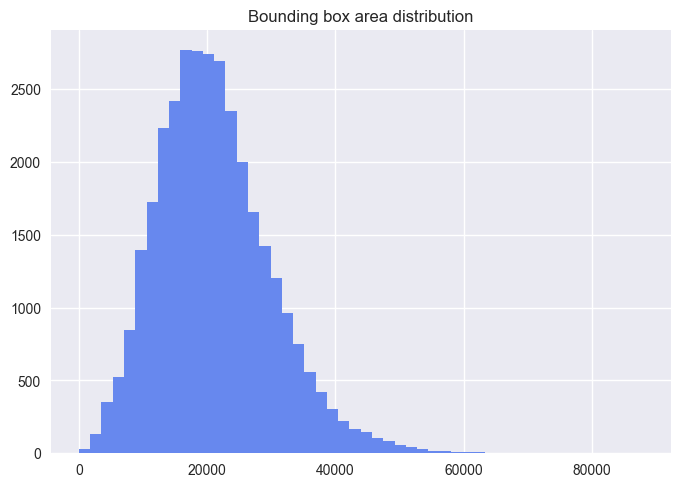

In [14]:
box_areas = [w*h for d in train_data for _,x,y,w,h in d["boxes"]]
plt.hist(box_areas, bins=50)
plt.title("Bounding box area distribution")


Most bounding boxes are small (around 10k–25k px), showing that pedestrians usually occupy a small part of the frame. The right-skewed shape indicates a few larger, close-up cases, so the model needs good small-object detection capability.

Total images: 11782
Average pedestrians per image: 2.82
Max pedestrians in one image: 13


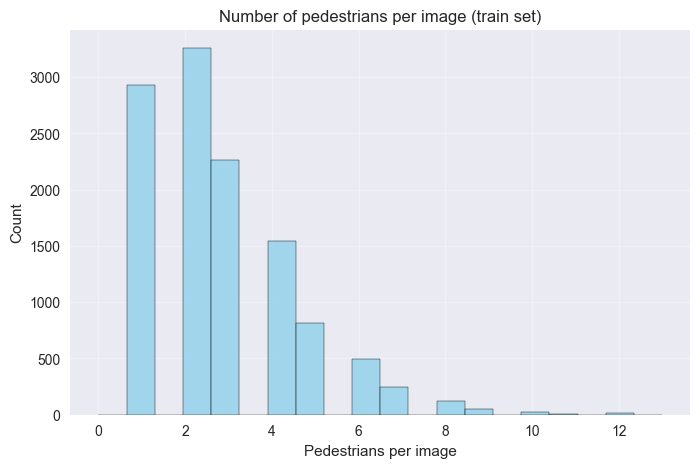

In [15]:
# count how many boxes(pedestrians) per image 

# count how many boxes per image
num_people = [len(item["boxes"]) for item in train_data]

print(f"Total images: {len(num_people)}")
print(f"Average pedestrians per image: {np.mean(num_people):.2f}")
print(f"Max pedestrians in one image: {np.max(num_people)}")

# quick look at the distribution
plt.figure(figsize=(8,5))
sns.histplot(num_people, bins=20, color='skyblue', kde=False)
plt.title("Number of pedestrians per image (train set)")
plt.xlabel("Pedestrians per image")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


Most images contain only one or two pedestrians, while a smaller portion includes larger groups.
This indicates that the dataset is dominated by sparse scenes, so the model should focus on detecting small, isolated targets rather than dense crowds.

# 3. Data Preprocessing and Augmentation Setup

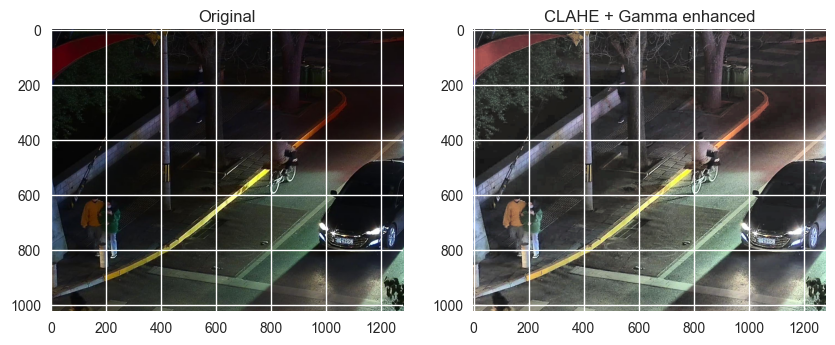

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_low_light(img, use_clahe=True, use_gamma=True):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)

    if use_gamma:
        gamma = 1.5
        invGamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
        l = cv2.LUT(l, table)

    enhanced = cv2.merge((l,a,b))
    return cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)


# quick visual test
sample = cv2.imread(str(TRAIN_IMG_DIR / train_data[0]['image']))
enh = enhance_low_light(sample, use_clahe=True, use_gamma=True)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)); plt.title("CLAHE + Gamma enhanced")
plt.show()


In [18]:
train_transforms = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),  # <-- adds gamma variation
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.3),
    A.Normalize()
])


# 4. Convert annotations to YOLO format

In [20]:
import os, shutil
from pathlib import Path
from tqdm import tqdm
import cv2

# base paths
DATA_ROOT = Path("find-person-in-the-dark")
TRAIN_IMG_DIR = DATA_ROOT / "train" / "train" / "train_images"
TEST_IMG_DIR  = DATA_ROOT / "test" / "test" / "test_images"
TRAIN_TXT = DATA_ROOT / "train_data.txt"
TEST_TXT  = DATA_ROOT / "test_data.txt"

# output structure
YOLO_ROOT = Path("yolo_data_txt")
for sub in ["images/train", "labels/train", "images/test"]:
    (YOLO_ROOT / sub).mkdir(parents=True, exist_ok=True)

def convert_to_yolo(x, y, w, h, img_w, img_h):
    x_c = (x + w/2) / img_w
    y_c = (y + h/2) / img_h
    w_n = w / img_w
    h_n = h / img_h
    return x_c, y_c, w_n, h_n

# --- TRAIN CONVERSION ---
with open(TRAIN_TXT, "r") as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Converting train_data.txt"):
    parts = line.strip().split()
    img_name = parts[0]
    img_path = TRAIN_IMG_DIR / img_name

    img = cv2.imread(str(img_path))
    if img is None:
        continue
    h, w = img.shape[:2]

    # write YOLO label
    label_path = YOLO_ROOT / f"labels/train/{Path(img_name).stem}.txt"
    with open(label_path, "w") as out:
        i = 1
        while i < len(parts):
            cls = parts[i]  # should be "person"
            x, y, bw, bh = map(int, parts[i+1:i+5])
            x_c, y_c, bw_n, bh_n = convert_to_yolo(x, y, bw, bh, w, h)
            out.write(f"0 {x_c:.6f} {y_c:.6f} {bw_n:.6f} {bh_n:.6f}\n")
            i += 5

    # copy image
    dst_img = YOLO_ROOT / f"images/train/{img_name}"
    shutil.copy(img_path, dst_img)

print("Training data converted.")

# test data
test_img_out = YOLO_ROOT / "images" / "test"
test_img_out.mkdir(parents=True, exist_ok=True)  # make sure folder exists

with open(TEST_TXT, "r") as f:
    test_files = [line.strip().split()[0] for line in f]

for img_name in tqdm(test_files, desc="Copying test images"):
    src_img = TEST_IMG_DIR / img_name
    dst_img = test_img_out / img_name

    # double check folders
    dst_img.parent.mkdir(parents=True, exist_ok=True)

    if src_img.exists():
        shutil.copy(src_img, dst_img)

print("Test data ready")


Converting train_data.txt: 100%|██████████| 11782/11782 [01:57<00:00, 100.43it/s]


Training data converted.


Copying test images: 100%|██████████| 3248/3248 [00:23<00:00, 137.28it/s]

Test data ready


In [21]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

YOLO_ROOT = Path("yolo_data_txt")
img_dir = YOLO_ROOT / "images/train"
lbl_dir = YOLO_ROOT / "labels/train"

img_paths = sorted(list(img_dir.glob("*.jpg")))
train_imgs, val_imgs = train_test_split(img_paths, test_size=0.1, random_state=42)

# make val dirs
(YOLO_ROOT / "images/val").mkdir(parents=True, exist_ok=True)
(YOLO_ROOT / "labels/val").mkdir(parents=True, exist_ok=True)

# move files
for img_path in val_imgs:
    lbl_path = lbl_dir / f"{img_path.stem}.txt"
    shutil.copy(img_path, YOLO_ROOT / "images/val" / img_path.name)
    if lbl_path.exists():
        shutil.copy(lbl_path, YOLO_ROOT / "labels/val" / lbl_path.name)

print(f"Split complete: {len(train_imgs)} train, {len(val_imgs)} val images.")


Split complete: 10603 train, 1179 val images.


In [23]:
YOLO_ROOT = Path("yolo_data_txt")

yaml_content = f"""
train: {str((YOLO_ROOT / 'images/train').resolve())}
val: {str((YOLO_ROOT / 'images/val').resolve())}

nc: 1
names: ['person']
"""

yaml_path = YOLO_ROOT / "data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("data.yaml saved:", yaml_path)


data.yaml saved: yolo_data_txt\data.yaml


# 5. Model training

YOLOv8 is a fast and accurate object detector from Ultralytics. It’s lightweight, easy to train, and works well for small, low-contrast targets like pedestrians in dark scenes. Its built-in augmentations, adaptive image scaling, and GPU-optimized design make it a solid choice for this low-light detection task.

In [ ]:
from ultralytics import YOLO
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


first, I will try to create a model with a small yolov8n

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

# Start training
results = model.train(
    data="yolo_data_txt/data.yaml", 
    epochs=50,      
    imgsz=640,   
    batch=16,       
    device=0,        
    project="runs",
    name="find_person_dark",
    exist_ok=True
)


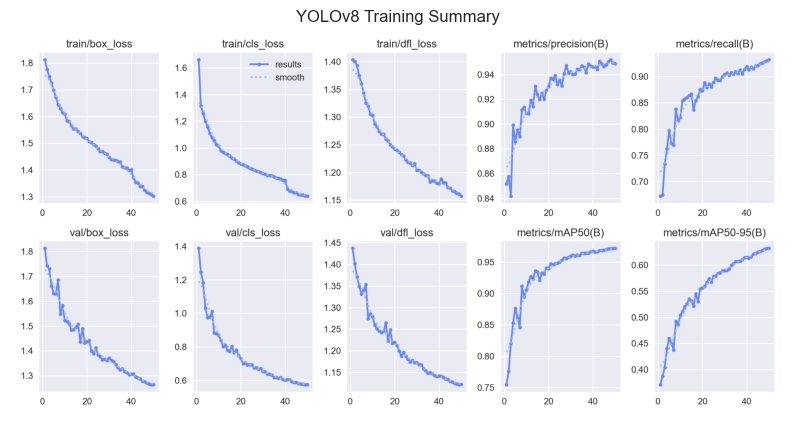

In [25]:


results_path = Path("runs/find_person_dark/results.png")
img = cv2.imread(str(results_path))
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8 Training Summary")
plt.axis("off")
plt.show()


In [28]:


csv_path = Path("runs/find_person_dark/results.csv")
df = pd.read_csv(csv_path)
df.tail()


epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
45     46  4728.93         1.32381         0.65137         1.16686   
46     47  4821.26         1.31698         0.64808         1.16562   
47     48  4913.34         1.31314         0.64811         1.16217   
48     49  5003.18         1.30876         0.64126         1.16124   
49     50  5096.85         1.30224         0.63878         1.15720   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
45               0.94786            0.92445           0.96987   
46               0.95033            0.92585           0.97067   
47               0.95193            0.92735           0.97166   
48               0.94933            0.93008           0.97164   
49               0.94883            0.93197           0.97171   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
45              0.62620       1.27599       0.58304       1.12739  0.000218   
46              0.62800       1.27045       0.57962       1.12453  0.000178   
47              0.63052       1.26649       0.57887       1.12322  0.000139   
48              0.63151       1.26312       0.57427       1.12141  0.000099   
49              0.63193       1.26325       0.57416       1.12214  0.000060   

      lr/pg1    lr/pg2  
45  0.000218  0.000218  
46  0.000178  0.000178  
47  0.000139  0.000139  
48  0.000099  0.000099  
49  0.000060  0.000060

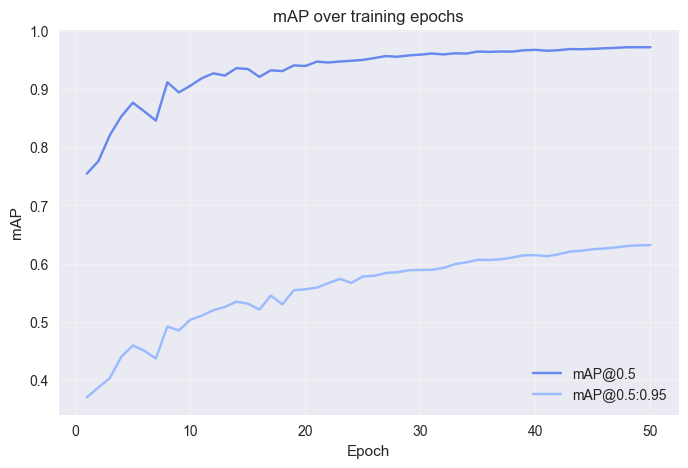

In [31]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("mAP over training epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


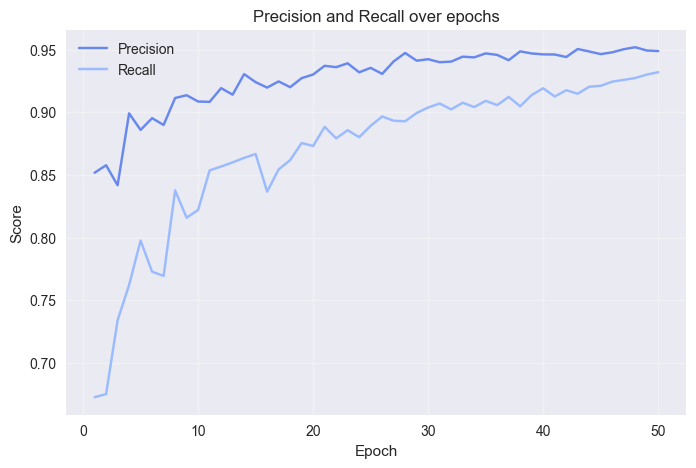

In [32]:
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision and Recall over epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [33]:
from ultralytics import YOLO

model = YOLO("runs/find_person_dark/weights/best.pt")
metrics = model.val()
print(metrics)


Ultralytics 8.3.199  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 22.914.8 MB/s, size: 193.3 KB)
val: Scanning D:\Interview_assignment\yolo_data_txt\labels\val.cache... 1179 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1179/1179  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 74/74 7.9it/s 9.4s0.1ss
                   all       1179       3203      0.948      0.931      0.971      0.632
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to D:\Interview_assignment\runs\detect\val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002A4BF2329D0>
curve


image 1/1 d:\Interview_assignment\yolo_data_txt\images\test\190001.jpg: 512x640 2 persons, 48.3ms
Speed: 11.5ms preprocess, 48.3ms inference, 29.8ms postprocess per image at shape (1, 3, 512, 640)


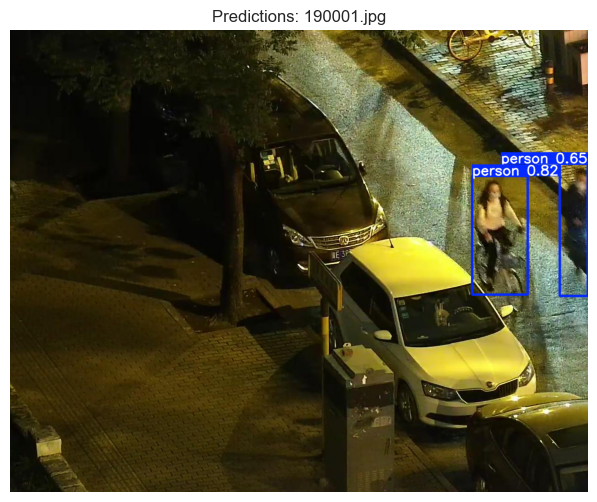


image 1/1 d:\Interview_assignment\yolo_data_txt\images\test\190002.jpg: 512x640 1 person, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 640)


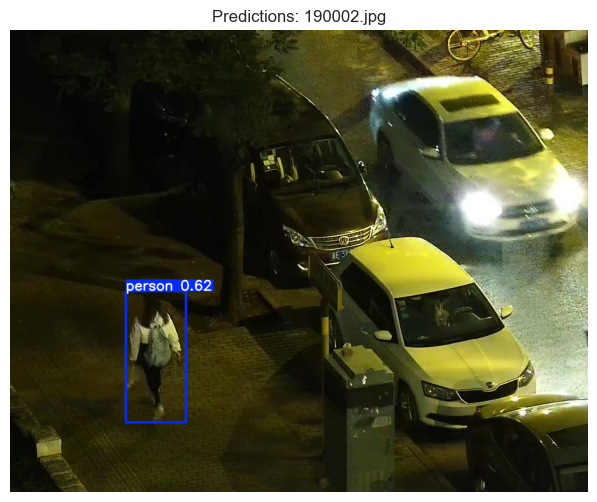


image 1/1 d:\Interview_assignment\yolo_data_txt\images\test\190003.jpg: 512x640 6 persons, 14.1ms
Speed: 2.3ms preprocess, 14.1ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


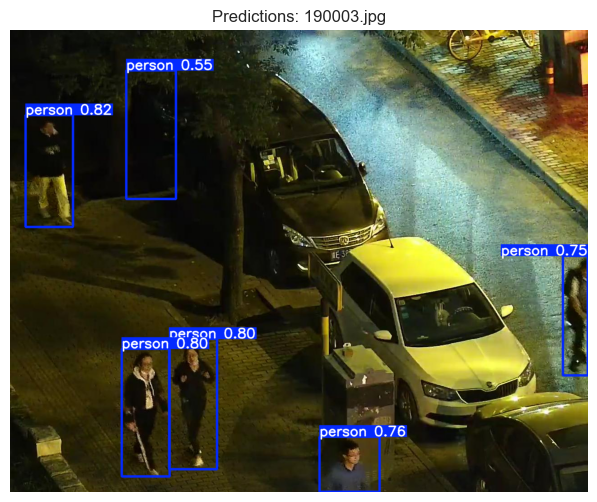


image 1/1 d:\Interview_assignment\yolo_data_txt\images\test\190004.jpg: 512x640 1 person, 14.8ms
Speed: 2.5ms preprocess, 14.8ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)


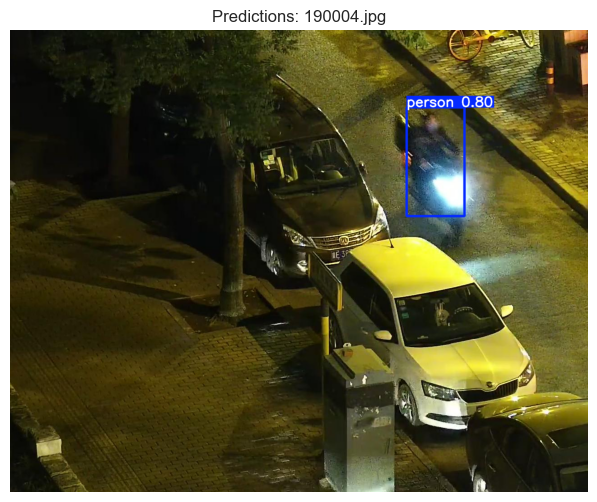


image 1/1 d:\Interview_assignment\yolo_data_txt\images\test\190005.jpg: 512x640 1 person, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 7.7ms postprocess per image at shape (1, 3, 512, 640)


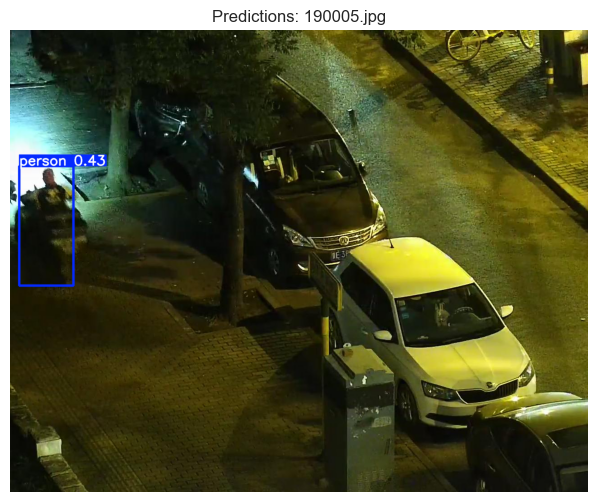

In [34]:

model = YOLO("runs/find_person_dark/weights/best.pt")
sample_imgs = list(Path("yolo_data_txt/images/test").glob("*.jpg"))[:5]

for img_path in sample_imgs:
    results = model.predict(img_path, conf=0.3)
    img_out = results[0].plot()
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions: {img_path.name}")
    plt.axis("off")
    plt.show()


The visual examples show that the trained YOLOv8n model can detect pedestrians even in very dark or low-contrast scenes. The detections remain stable across varying brightness and scale levels.

The YOLOv8n model was trained for 50 epochs on 640×640 images with a batch size of 16 using an RTX 4060 Laptop GPU. Training completed in about 87 minutes.
Precision = 0.948

Recall = 0.931

mAP@0.5 = 0.971

mAP@0.5:0.95 = 0.632

These metrics indicate that the model correctly identifies most pedestrians (high recall) and makes very few false detections (high precision). The high mAP@0.5 reflects excellent detection accuracy, while the moderate mAP@0.5:0.95 suggests some localization variability on smaller or darker targets. Overall, the model achieved stable, high-quality results for low-light pedestrian detection within a compact training setup.